In [1]:
import pandas as pd
import os
import sys
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
sys.path.append(parent_dir)
from src.prep_vid_v2 import get_images_tensor
import pyarrow.parquet as pq
from pathlib import Path
from tqdm import tqdm
from src.model import load_model
from src.utils import calculate_eer
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np


d:\Projekt\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Projekt\venv\Lib\site-packages\facenet_pytorch\models\mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start set

In [2]:
parent_dir

'd:\\Projekt'

In [3]:
df = pd.read_parquet(parent_dir + '/data/demo/swan_random.parquet')

In [4]:
df

,embedding,class,path
0,"[0.029369256, -0.015046592, 0.048494834, 0.020...",00001,data/SwanDF/iPad/00001/4_00001_m_01_01_t_1.mp4
1,"[0.024639698, -0.01156279, 0.05003506, 0.01598...",00001,data/SwanDF/iPad/00001/4_00001_m_01_01_t_1.mp4
2,"[0.04751341, -0.0101910345, 0.04751451, -0.019...",00001,data/SwanDF/iPad/00001/4_00001_m_01_01_t_2.mp4
3,"[0.01909381, -0.012367023, 0.027704664, -0.043...",00001,data/SwanDF/iPad/00001/4_00001_m_01_01_t_2.mp4
4,"[0.046623845, -0.022280011, 0.041588213, -0.02...",00001,data/SwanDF/iPad/00001/4_00001_m_01_01_t_2.mp4
...,...,...,...
6556,"[-0.026061276, 0.073861316, 0.0358118, -0.0057...",00060,data/SwanDF/iPhone/00060/4_00060_f_01_08_p_2.mp4
6557,"[-0.03635716, 0.035351638, 0.021597415, 0.0312...",00060,data/SwanDF/iPhone/00060/4_00060_f_01_08_p_2.mp4
6558,"[-0.024802946, 0.03075525, 0.02514618, 0.00995...",00060,data/SwanDF/iPhone/00060/4_00060_f_01_08_p_2.mp4
6559,"[-0.045787793, 0.05570296, 0.03962775, 0.03085...",00060,data/SwanDF/iPhone/00060/4_00060_f_01_08_p_2.mp4


In [5]:
model = load_model('adaface')

d:\Projekt\models\AdaFace\inference.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  statedict = torch.load(adaface_models[architecture])['state_dict']


In [6]:
labels = df['class'].values
embeddings = df['embedding']
# embeddings = np.array([np.array(ast.literal_eval(e)) for e in embeddings])
print(type(embeddings))
embeddings = np.array(embeddings.tolist())
print(embeddings.shape)
num_samples = len(embeddings)
scores = []
class_labels = []
chunk_size = 5000
for i in range(0, num_samples, chunk_size):
    for j in range(i + 1, num_samples, chunk_size):
        print("Processing chunk", i, j)

        emb_chunk = embeddings[i:i + chunk_size]
        emb_chunk_2 = embeddings[j:j + chunk_size]

        score_chunk = model.compute_similarities(emb_chunk, emb_chunk_2)

        labels_chunk = labels[i:i + chunk_size]
        labels_chunk_2 = labels[j:j + chunk_size]
        labels_matrix = np.equal(labels_chunk[:, None], labels_chunk_2)
        np.fill_diagonal(labels_matrix, False)

        upper_triangle_indices = np.triu_indices_from(score_chunk, k=1)
        try:
            class_label = labels_matrix[upper_triangle_indices]
            score = score_chunk[upper_triangle_indices]
            class_labels.extend(class_label)
            scores.extend(score)
        except:
            continue

data = pd.DataFrame({
    'label': class_labels,
    'score': scores
})

<class 'pandas.core.series.Series'>
(6561, 512)
Processing chunk 0 1
Processing chunk 0 5001
Processing chunk 5000 5001


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
palette = {
    'Different identity': 'red',
    'Same identity': 'green'
}

In [9]:
label_map = {False: 'Different identity', True: 'Same identity'}
data['group_label'] = data['label'].map(label_map)

In [10]:
sns.set_context("paper", font_scale=2)
plt.rcParams['font.family'] = 'serif'

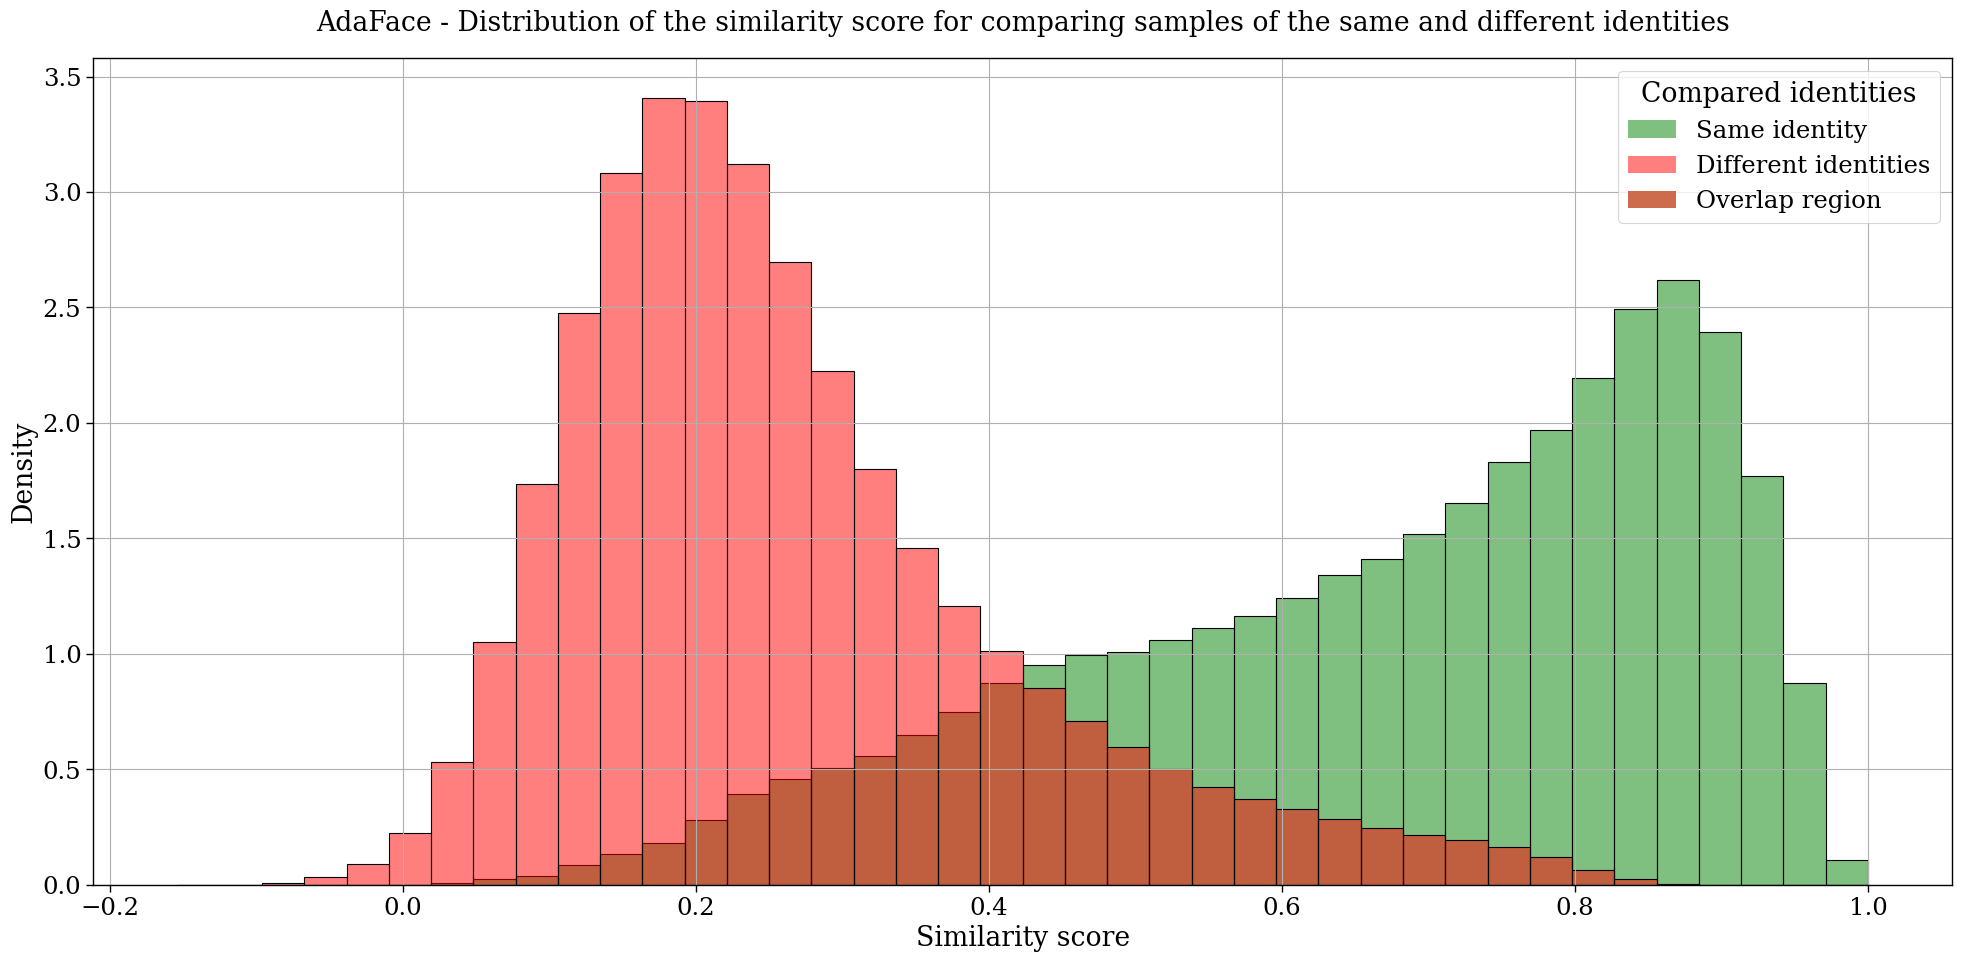

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Zmień kolejność kategorii (np. żeby 'Same identity' był na górze)
data['group_label'] = pd.Categorical(
    data['group_label'],
    categories=['Different identity', 'Same identity'],  # dolna, potem górna warstwa
    ordered=True
)

# Rysuj wykres
plt.figure(figsize=(20, 10))
ax = sns.histplot(
    data=data,
    x='score',
    hue='group_label',
    bins=40,
    stat='density',
    common_norm=False,
    palette=palette
)

plt.title('AdaFace - Distribution of the similarity score for comparing samples of the same and different identities', pad=20)
plt.xlabel('Similarity score')
plt.tight_layout()
plt.grid()

# Nowa legenda
legend_elements = [
    Patch(facecolor=palette['Same identity'], label='Same identity', alpha=0.5),
    Patch(facecolor=palette['Different identity'], label='Different identities', alpha=0.5),
    Patch(facecolor='#C75C3A', label='Overlap region', alpha=0.9)
]
ax.legend(handles=legend_elements, title='Compared identities')


In [12]:
thresholds = np.linspace(-0.2, 1, 121)

In [ ]:
accs = []
fars = []
frrs = []

In [ ]:
ground_truth = data['label']
for t in thresholds:
    decisions = data['score'] > t
    acc = accuracy_score(ground_truth, decisions)
    FP = np.sum((ground_truth == 0) & (decisions == 1))
    FN = np.sum((ground_truth == 1) & (decisions == 0))
    TP = np.sum((ground_truth == 1) & (decisions == 1))
    TN = np.sum((ground_truth == 0) & (decisions == 0))
    FAR = FP / (FP + TN)
    FRR = FN / (FN + TP)
    fars.append(FAR)
    frrs.append(FRR)
    accs.append(acc)
    

In [15]:
threshold, eer = calculate_eer(thresholds, fars, frrs)

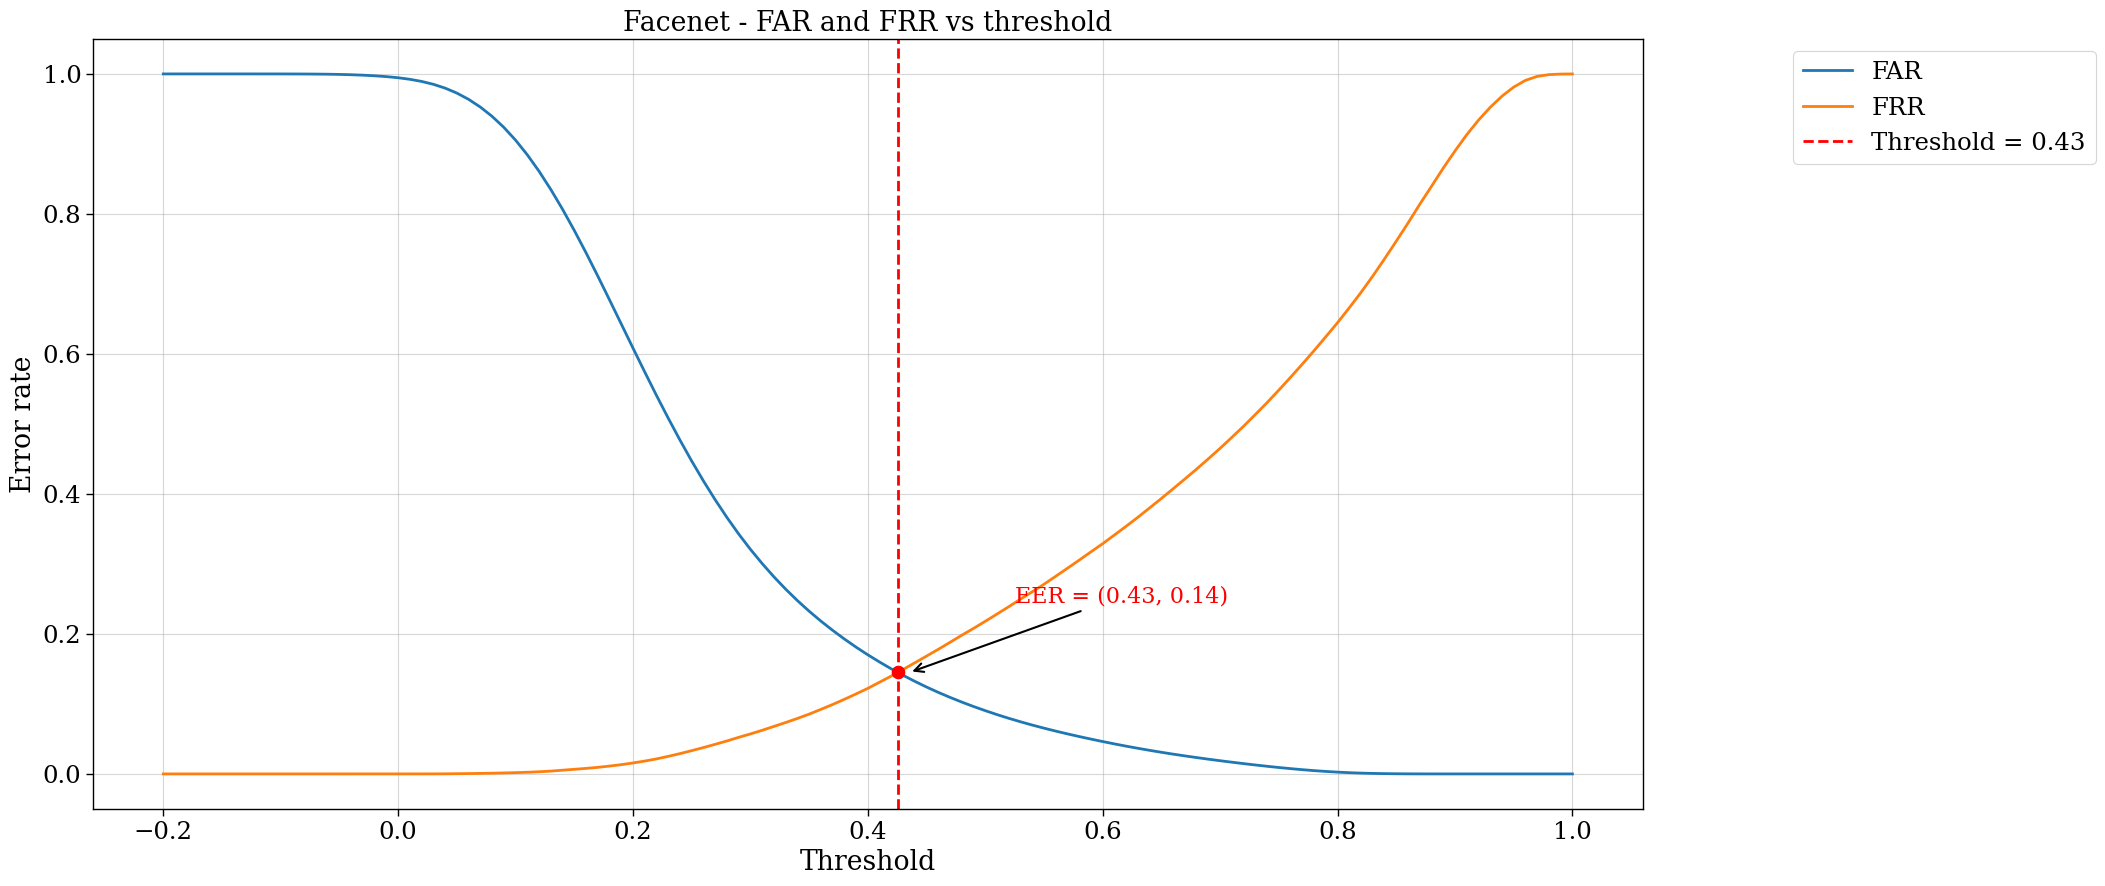

In [16]:
plt.figure(figsize=(20, 10))
plt.plot(thresholds, fars, label='FAR', linewidth=2)
plt.plot(thresholds, frrs, label='FRR', linewidth=2)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.2f}', linewidth=2)
plt.scatter(threshold, eer, color='red', zorder=2, linewidth=5)
plt.annotate(
    f'EER = ({threshold:.2f}, {eer:.2f})', 
    xy=(threshold+0.01, eer), 
    xytext=(threshold + np.max(thresholds)/10, eer + 0.1),  # Adjust text position
    arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=1.5),
    fontsize=16,
    color='red',
)
plt.title('Facenet - FAR and FRR vs threshold')
plt.xlabel('Threshold')
plt.ylabel('Error rate')
plt.grid(alpha=0.5)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

In [20]:
decisions = data['score']> threshold
rec = recall_score(ground_truth, decisions)
FP = np.sum((ground_truth == 0) & (decisions == 1))
FN = np.sum((ground_truth == 1) & (decisions == 0))
TP = np.sum((ground_truth == 1) & (decisions == 1))
TN = np.sum((ground_truth == 0) & (decisions == 0))
FAR = FP / (FP + TN)
FRR = FN / (FN + TP)
print(f'Accuracy: {round(acc, 5)}')
print(f'FAR: {round(FAR, 7)}')
print(f'FRR: {round(FRR, 5)}')
print(f"EER: {round(eer, 5)}")

Accuracy: 0.85505
FAR: 0.1449437
FRR: 0.14508
EER: 0.145
